In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

basins=geopandas.read_file("../datasets/basins/basins_with_climate_zones.shp")
basins.set_index("NAME",inplace=True)

In [3]:
Nbasins=basins.shape[0]
Ndatasets=1694
data_TWS='GRACE_JPL_mascons'
min_year=2003
max_year=2014

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [5]:
NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])
NSEc_tab=pd.read_csv("../results/water_budget/NSE_cyclic_tab_{}_{}_{}basins_{}datasets_{}.csv".format(min_year,
                                                                max_year,Nbasins,Ndatasets,data_TWS),index_col=[0])

In [5]:
list_data_P=['CPC','CRU','GPCC',
    'ERA5_Land','MERRA2','JRA55',
    'GPCP','GPM','TRMM',
    'GLDAS20','MSWEP',]

list_data_ET=['ERA5_Land','MERRA2','JRA55',
              'FLUXCOM','MOD16',
              'GLEAM',
              'SSEBop',
              'GLDAS20_NOAH36','GLDAS21_NOAH36',
              'GLDAS20_CLSM25','GLDAS21_CLSM25','GLDAS22_CLSM25',
              'GLDAS20_VIC412','GLDAS21_VIC412',
              ]

list_data_R=['ERA5_Land','MERRA2','JRA55',
             'GLDAS20_NOAH36','GLDAS21_NOAH36',
             'GLDAS20_CLSM25','GLDAS21_CLSM25','GLDAS22_CLSM25',
             'GLDAS20_VIC412','GLDAS21_VIC412',
             'GRUN',]

In [6]:
def construct_datasets(hydro_var_name,data):
    datasets1=[]
    if hydro_var_name=='P':
        for d_ET in list_data_ET:
            for d_R in list_data_R:
                datasets1.append('P_{}_ET_{}_R_{}_TWS_{}'.format(data,d_ET,d_R,data_TWS))
    elif hydro_var_name=='ET':
        for d_P in list_data_P:
            for d_R in list_data_R:
                datasets1.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,data,d_R,data_TWS))
    elif hydro_var_name=='R':
        for d_P in list_data_P:
            for d_ET in list_data_ET:
                datasets1.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,data,data_TWS))
    return datasets1

In [7]:
def mean_10th_best(datasets_,ncomb=10):
    mean10=pd.Series(np.zeros(NSE_tab.shape[0]),index=NSE_tab.index)
    for basin_name in NSE_tab.index:
        mean10.loc[basin_name]=NSE_tab.loc[basin_name,datasets_].sort_values(ascending=False).iloc[:ncomb].mean()
    return mean10

In [9]:
my_index=NSE_tab.loc[(np.nanmax(NSE_tab,axis=1)>0.8)|(np.nanmax(NSEc_tab,axis=1)>0.1)].index

## Compare 2 datasets

In [32]:
hydro_var_name='ET'
data1='GLDAS20_CLSM25'
data2='GLDAS21_CLSM25'

datasets1=construct_datasets(hydro_var_name,data1)
datasets2=construct_datasets(hydro_var_name,data2)

<IPython.core.display.Javascript object>


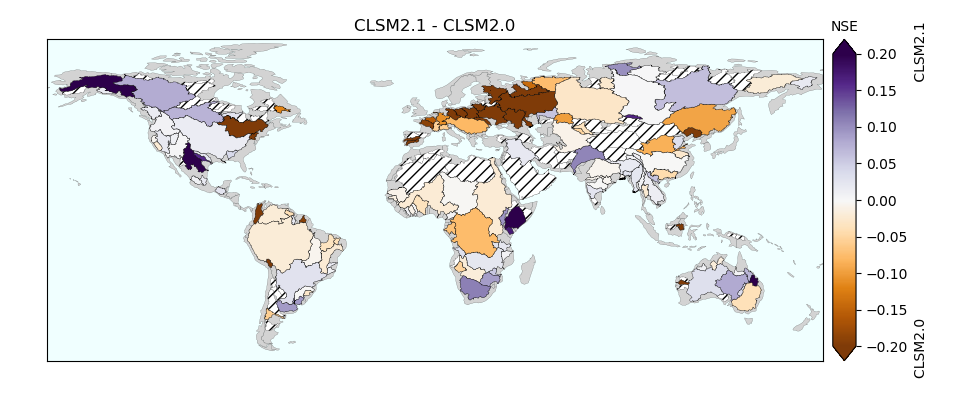

In [33]:
basins_plot=basins.copy()
#basins_plot['max1']=np.nanmax(NSE_tab.loc[:,datasets1],axis=1)
#basins_plot['max2']=np.nanmax(NSE_tab.loc[:,datasets2],axis=1)
#basins_plot['max2 - max1']=basins_plot['max2']-basins_plot['max1']
basins_plot['max2 - max1']=mean_10th_best(datasets2,ncomb=10)-mean_10th_best(datasets1,ncomb=10)

vmin=-0.2 #np.nanmin(basins_plot['max2 - max1'])
vmax=0.2 #np.nanmax(basins_plot['max2 - max1'])

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins.loc[(np.nanmax(NSE_tab,axis=1)<=0.8)&(np.nanmax(NSEc_tab,axis=1)<=0.1)].plot(ax=ax,facecolor='white',hatch='///',
                                      edgecolor='black',linewidth=0.1)
basins_plot.loc[my_index].plot(ax=ax,column='max2 - max1',edgecolor='black',linewidth=0.2,
                 cmap=plt.cm.get_cmap('PuOr'),
                 norm=MidpointNormalize(vmin=vmin,vmax=vmax,midpoint=0),
                 vmin=vmin,vmax=vmax,
                 legend=True,cax=cax,
                 legend_kwds={'label': "{}                                                      {}".format(dict_dataset_name[data1],
                                                                                                           dict_dataset_name[data2]),
                              'extend':'both',
                          },
                )
cax.set_title('NSE',fontsize=10)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} - {}'.format(dict_dataset_name[data2],dict_dataset_name[data1]))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


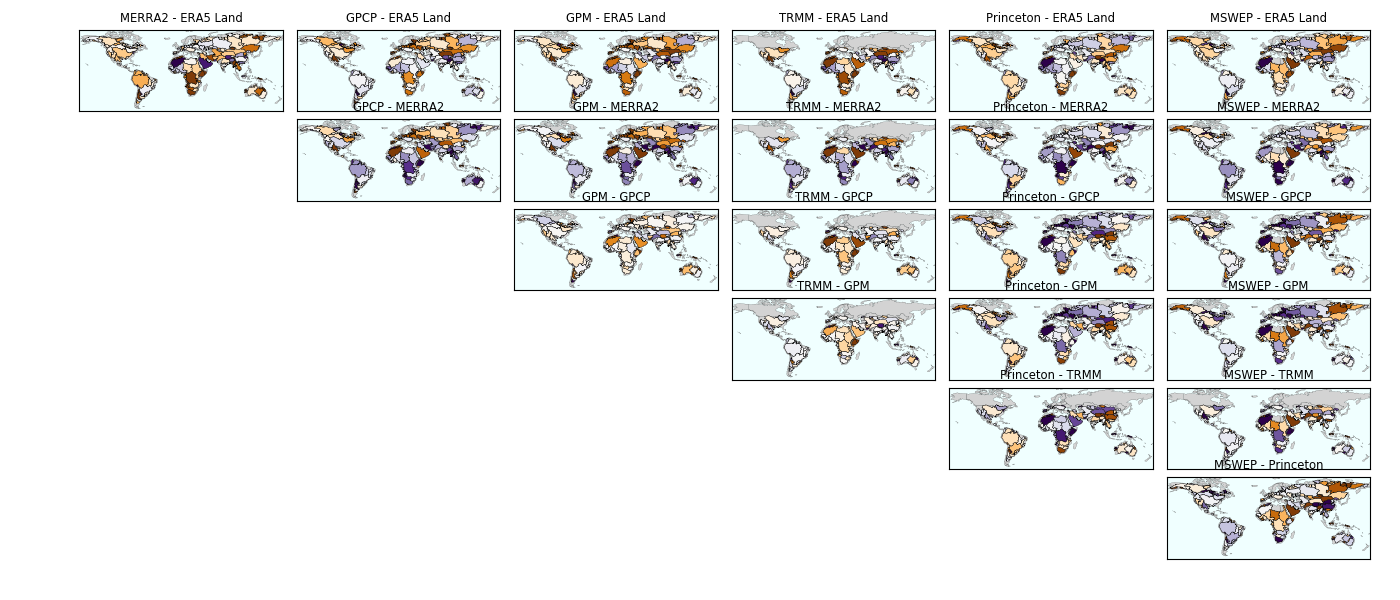

c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c:\users\fafal\miniconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered
c

In [14]:
hydro_var_name='P'
list_data=list_data_P

basins_plot=basins.copy()
fig, axs = plt.subplots(len(list_data),len(list_data), figsize=(14,6))
vmin=-0.2
vmax=0.2

for i1,data1 in enumerate(list_data):
    for i2,data2 in enumerate(list_data):
        if i2==i1:
            ax=axs[i1,i2]
            ax.set_axis_off()
        elif i2<i1:
            ax=axs[i1,i2]
            ax.set_axis_off()
        else:
            datasets1=construct_datasets(hydro_var_name,data1)
            datasets2=construct_datasets(hydro_var_name,data2)
            basins_plot[data1]=np.nanmax(NSE_tab.loc[:,datasets1],axis=1)
            basins_plot[data2]=np.nanmax(NSE_tab.loc[:,datasets2],axis=1)
            basins_plot['{} - {}'.format(data2,data1)]=basins_plot[data2]-basins_plot[data1]

            ax=axs[i1,i2]
            ax.set_aspect('equal')
            world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
            basins_plot.plot(ax=ax,column='{} - {}'.format(data2,data1),edgecolor='black',linewidth=0.2,
                     cmap=plt.cm.get_cmap('PuOr'),
                     norm=MidpointNormalize(vmin=vmin,vmax=vmax,midpoint=0),
                     vmin=vmin,vmax=vmax,
                    )
            ax.set_facecolor('azure')
            ax.set_title('{} - {}'.format(dict_dataset_name[data2],dict_dataset_name[data1]),fontsize='small')
            ax.set_xlim([-170,180])
            ax.set_ylim([-60,80])
            ax.set_xticks([])
            ax.set_yticks([])
plt.subplots_adjust(left=-0.1,right=0.98,bottom=-0.08,top=0.95,wspace=0.05,hspace=0.1)
plt.show()

## 1 dataset vs all others

In [42]:
hydro_var_name='R'
data1='GLDAS20_VIC412'
   
datasets1=construct_datasets(hydro_var_name,data1)
datasets=list(set(NSE_tab.columns)-set(datasets1))

<IPython.core.display.Javascript object>


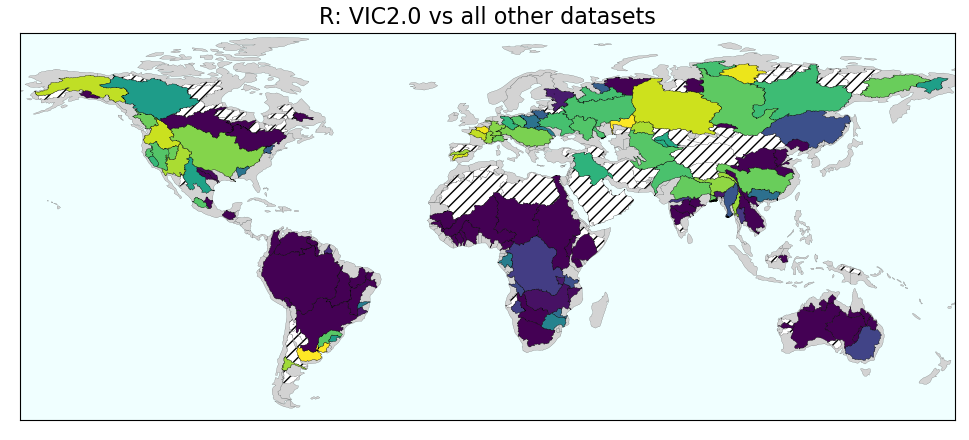

In [43]:
legend=False

basins_plot=basins.copy()
basins_plot['better {}'.format(data1)]=mean_10th_best(datasets1,ncomb=10)-mean_10th_best(datasets,ncomb=10)

fig, ax = plt.subplots(figsize=(9.7,4.4))
ax.set_aspect('equal')
if legend:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
#basins.plot(ax=ax,color='white',edgecolor='black',linewidth=0.5)
basins_plot.loc[(np.nanmax(NSE_tab,axis=1)<=0.8)&(np.nanmax(NSEc_tab,axis=1)<=0.1)&(~np.isnan(basins_plot['better {}'.format(data1)]))].plot(ax=ax,
                                                                                    facecolor='white',hatch='///',
                                                                                    edgecolor='black',linewidth=0.1)
basins_plot.loc[my_index].plot(ax=ax,column='better {}'.format(data1),edgecolor='black',linewidth=0.2,
                 cmap=plt.cm.get_cmap('viridis'),
                 vmin=-0.2,vmax=0,
                 #legend=legend,cax=cax,
                 legend_kwds={'label': "NSE difference",
                              'extend':'both',
                              'orientation':'horizontal'
                          },
                )
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{}: {} vs all other datasets'.format(hydro_var_name,dict_dataset_name[data1]),fontsize=16)
plt.tight_layout()
plt.show()

In [38]:
basins_plot['better {}'.format(data1)].sort_values()

NAME
MAMBERAMO         -2.228343
LAKE GAIRDNER     -1.389165
Salinas Grandes   -1.309433
MAR CHIQUITA      -1.250590
HAYES             -1.045505
                     ...   
UVS NUUR           0.088792
MELRHIR            0.113442
RHARSA             0.162461
HAR US NUUR        0.168151
Ogaden plateau     1.148836
Name: better ERA5_Land, Length: 189, dtype: float64